## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
# Your experiments here

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data.zip

In [ ]:
import os
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
from sklearn.metrics import f1_score
import torchsummary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
train_dataset=datasets.ImageFolder('/content/data/train',transform)

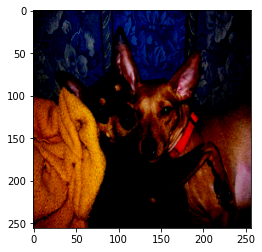

In [ ]:
plt.imshow(torch.permute(next(iter(train_dataset))[0],(1,2,0)).to('cpu').numpy())

In [ ]:
len_train = int(len(train_dataset) * 0.75)
tr, vl=torch.utils.data.random_split(train_dataset, [len_train, len(train_dataset) - len_train])
len(tr), len(vl)

(5374, 1792)

In [ ]:
valid=torch.utils.data.DataLoader(vl, batch_size=8,shuffle=False, num_workers=2)
train=torch.utils.data.DataLoader(tr, batch_size=8,shuffle=True, num_workers=2)
loader={'train':train,'valid':valid}

In [ ]:
model = models.densenet161(pretrained=True) # 0.93
for param in model.parameters():
    param.requires_grad = False
model.classifier=nn.Linear(in_features=2208, out_features=50)
model=model.to(device)

In [ ]:
model = models.densenet161(pretrained=True) # best result
for param in model.parameters():
    param.requires_grad = False
model.classifier=nn.Linear(in_features=2208, out_features=50)
model.features.denseblock4.denselayer24.requires_grad = True
model=model.to(device)

In [ ]:
model = models.alexnet()
model.classifier[6]=nn.Linear(in_features=4096, out_features=50)
model=model.to(device)

In [ ]:
model = models.resnet50(pretrained=True) # 0.91

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048,50)
model = model.to(device)

In [ ]:
model = models.resnet50(pretrained=True) #overfit
model.fc = nn.Linear(2048,50)
model = model.to(device)

In [ ]:
cross = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.1)

In [ ]:
max_epochs = 30 
best_val_accuracy = 0
best_train_accuracy = 0
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    train_accuracy = 0
    for k, dataloader in loader.items():
        y_tr=torch.Tensor().to(device)
        y_pr=torch.Tensor().to(device)
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
            x_batch=x_batch.to(device)
            y_batch=y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad() 
                outp = model(x_batch)
                loss = cross(outp, y_batch) 
                loss.backward() 
                optimizer.step()
            else:
                model.eval() 
                with torch.no_grad():
                    outp = model(x_batch)
                y_tr=torch.cat((y_tr,y_batch),0)    
                y_pr=torch.cat((y_pr,outp.argmax(-1)),0)
            preds=outp.detach().argmax(-1)
            correct =int(torch.sum(preds==y_batch))
            all = y_batch.shape[0] 
            epoch_correct += correct
            epoch_all += all
        now_accuracy = epoch_correct/epoch_all
        accuracy[k].append(now_accuracy)
        if k == "train":
            print(f"Epoch: {epoch+1}")
            scheduler.step()
            train_accuracy = now_accuracy
        print(f"Loader: {k}. Accuracy: {now_accuracy}")
        if k=="valid":
            y_tr=y_tr.to('cpu').numpy()
            y_pr=y_pr.to('cpu').numpy()
            f1_sc=f1_score(y_tr, y_pr, average='macro')
            print(f'\t\tf1_score: {f1_sc}')
            if now_accuracy>best_val_accuracy and train_accuracy > best_train_accuracy:
                best_train_accuracy = train_accuracy
                best_val_accuracy = now_accuracy
                torch.save(model.state_dict(), "./model.pth")
                

train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.728321548195013


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9263392857142857
		f1_score: 0.9251789349043158


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.8959806475623372


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.94140625
		f1_score: 0.9385443058423448


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9149609229624116


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.93359375
		f1_score: 0.931870190957849


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9224041682173427


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9436383928571429
		f1_score: 0.940747837113018


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9359880908075922


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9369419642857143
		f1_score: 0.9344832702482847


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9372906587272051


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9352678571428571
		f1_score: 0.9330133104276409


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9439895794566431


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9285714285714286
		f1_score: 0.9262860307865988


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9490137700037217


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9285714285714286
		f1_score: 0.9270736134972276


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9505024190547079


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9324776785714286
		f1_score: 0.9299879096898285


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9551544473390399


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.94140625
		f1_score: 0.9387331877120347


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 11
Loader: train. Accuracy: 0.9743208038704876


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9441964285714286
		f1_score: 0.9419227248143156


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 12
Loader: train. Accuracy: 0.9797171566803126


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9458705357142857
		f1_score: 0.9438859028522107


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 13
Loader: train. Accuracy: 0.9778563453665798


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9475446428571429
		f1_score: 0.9459123589526867


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 14
Loader: train. Accuracy: 0.9771120208410867


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9458705357142857
		f1_score: 0.9444886457715345


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 15
Loader: train. Accuracy: 0.9795310755489394


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9441964285714286
		f1_score: 0.9426170649496639


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 16
Loader: train. Accuracy: 0.980647562337179


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9447544642857143
		f1_score: 0.9427227806514804


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 17
Loader: train. Accuracy: 0.9812058057312989


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9464285714285714
		f1_score: 0.9443017915794996


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 18
Loader: train. Accuracy: 0.9815779679940454


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9458705357142857
		f1_score: 0.9445207803261543


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 19
Loader: train. Accuracy: 0.9826944547822851


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9486607142857143
		f1_score: 0.9469220308867031


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 20
Loader: train. Accuracy: 0.9856717528842576


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9514508928571429
		f1_score: 0.9493885381203975


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 21
Loader: train. Accuracy: 0.981950130256792


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9475446428571429
		f1_score: 0.945833909053205


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 22
Loader: train. Accuracy: 0.9838109415705247


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9469866071428571
		f1_score: 0.9448464072061394


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 23
Loader: train. Accuracy: 0.9799032378116859


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9486607142857143
		f1_score: 0.947325275241731


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 24
Loader: train. Accuracy: 0.9841831038332713


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9503348214285714
		f1_score: 0.9489558525983433


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 25
Loader: train. Accuracy: 0.9817640491254187


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9464285714285714
		f1_score: 0.9452995144743404


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 26
Loader: train. Accuracy: 0.9841831038332713


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9464285714285714
		f1_score: 0.9441988543323194


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 27
Loader: train. Accuracy: 0.9825083736509118


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9464285714285714
		f1_score: 0.9450665465464928


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 28
Loader: train. Accuracy: 0.9841831038332713


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9475446428571429
		f1_score: 0.9464594116810885


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 29
Loader: train. Accuracy: 0.9817640491254187


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9447544642857143
		f1_score: 0.9425024559862416


train iter::   0%|          | 0/672 [00:00<?, ?it/s]

Epoch: 30
Loader: train. Accuracy: 0.9845552660960178


valid iter::   0%|          | 0/224 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9458705357142857
		f1_score: 0.9435792220447283


In [ ]:
best_val_accuracy, best_train_accuracy

(0.9514508928571429, 0.9856717528842576)

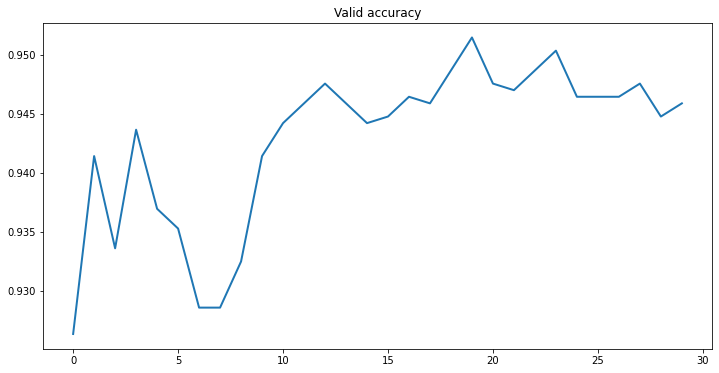

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), accuracy['valid'], linewidth=2)
plt.show()

In [ ]:
os.mkdir('/content/data/test_dir')
os.replace('/content/data/test', '/content/data/test_dir/test')

In [ ]:
transform_tr = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
train_dataset=datasets.ImageFolder('/content/data/test_dir',transform_tr)

In [ ]:
model = models.densenet161()
model.classifier=nn.Linear(in_features=2208, out_features=50)
model.load_state_dict(torch.load('/content/model.pth'))
model.to(device)
model.eval()

In [ ]:
label=[]
res=[]
for i in range(len(train_dataset)):
    with torch.no_grad():
        outp=model(train_dataset[i][0][None,:].to(device)).argmax(-1).item()
        res.append(outp)
    label.append(train_dataset.imgs[i][0][28:])  

In [ ]:
label[0:5], res[0:5]

(['0.jpeg', '1.jpeg', '10.jpeg', '100.jpeg', '1000.jpeg'],
 [37, 23, 33, 10, 29])

In [ ]:
df = pd.DataFrame({'img_name': label, 'label': res})

In [ ]:
df

,img_name,label
0,0.jpeg,37
1,1.jpeg,23
2,10.jpeg,33
3,100.jpeg,10
4,1000.jpeg,29
...,...,...
1498,995.jpeg,47
1499,996.jpeg,46
1500,997.jpeg,40
1501,998.jpeg,15


In [ ]:
%%capture cap_out --no-stderr
import sys

old_stdout = sys.stdout 
sys.stdout = open(r'res.csv', 'w')
print(df.to_csv(index=False))
sys.stdout = old_stdout

In [ ]:
pd.read_csv('/content/res.csv')

,img_name,label
0,0.jpeg,37
1,1.jpeg,23
2,10.jpeg,33
3,100.jpeg,10
4,1000.jpeg,29
...,...,...
1498,995.jpeg,47
1499,996.jpeg,46
1500,997.jpeg,40
1501,998.jpeg,15


* По началу пробовал alexnet, больших результатов получить не удалось, но долго обучать не пробовал (максимум 30 эпох)
* Потом resnet50. Без заморозки слоев он переобучивался. Пытался замораживать последние слои, но выше 0.91 не получилось, решил попробовать следующий вариант
* Взял densenet, с заморозкой всех слоев кроме последнего получилось 0.93 - хороший результат. Решил разморозить еще один блок, перед полносвязным, и добился еще лучшего результата (0.95).
* Также хотелось бы добавить, что при обучение learning rate каждые 10 эпох понижался в 10 раз.